This notebook analyzes the activity of freezing cells (those active during or before/after freezing epochs) across days and in response to ANI administration

In [21]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Import project specific modules and enable automatic reloading
import sys
sys.path.append(r'C:\Users\Nat\Documents\BU\Imaging\Python\Eraser')
sys.path.append(r'C:\Users\Nat\Documents\BU\Imaging\Python\FearReinstatement')
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For starters, look at one mouse and map velocity over calcium activity.

In [22]:
# Load in neural data and freezing data
mouse, arena, day = 'Marble07', 'Shock', -2
dir_use = erp.get_dir(mouse, arena, day)
PF = pf.load_pf(mouse, arena, day)

video_t = erp.get_timestamps(str(dir_use))
freezing, velocity = erp.detect_freezing(str(dir_use), arena=arena)
video_t = video_t[:-1]  # Chop off last timepoint to make this the same length as freezing and velocity arrays

# Now get time for imaging
t_imaging = np.arange(0, PF.PSAbool_align.shape[1])/PF.sr_image

C:\Users\Nat\Documents\BU\Imaging\Working\Eraser\Control Group\Marble7\20180319_2_fcbox: nbadpts = 2 max_in_a_row = 1


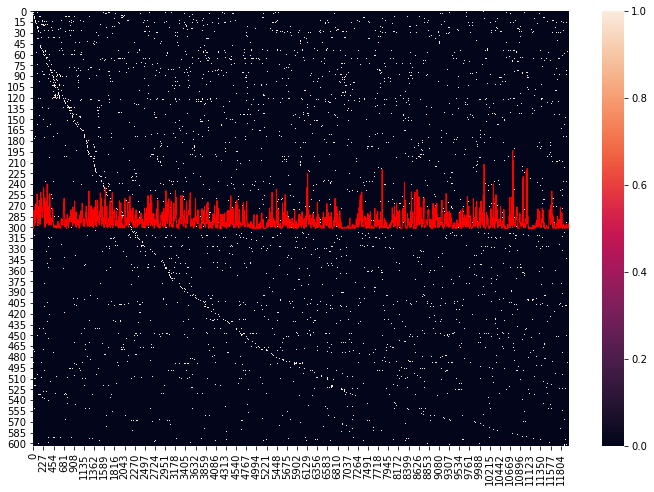

In [36]:
SFvel = 4  # Factor to scale velocity by for overlay below

fig, ax = plt.subplots()
fig.set_size_inches([12,8])
sns.heatmap(data=PF.PSAbool_align, ax=ax)
nneurons = PF.PSAbool_align.shape[0]
ax.plot(video_t*PF.sr_image, velocity*-SFvel+nneurons/2, color='r', linewidth=1)

In [34]:
video_t*20

array([0.00000e+00, 1.14000e+01, 1.60000e+01, ..., 1.19802e+04,
       1.19856e+04, 1.19908e+04])